In [48]:
from datetime import date, timedelta
import requests
import math
import requests
import pandas as pd
import numpy as np
from PIL import Image
import torch
import os
import ruclip
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from io import BytesIO
from sklearn.cluster import KMeans

from umap import UMAP
import plotly.graph_objects as go


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [35]:
def make_shard_url_base(sku):
    vol_num = math.floor(sku / 100000)
    part_num = math.floor(sku / 1000)
    shard_name = get_shard_name(vol_num)
    result = 'https:{}vol{}/part{}/{}'.format(shard_name, vol_num, part_num, sku)
    return result

def build_sku_spec_url(sku):
    result = '{}/info/ru/card.json'.format(make_shard_url_base(sku))
    return result

def build_sku_img_url(sku):
    result = '{}/images/c246x328/1.jpg'.format(make_shard_url_base(sku))
    return result

def get_shard_name(e) -> str:
    if 0 <= e <= 143:
        num = '01'
    elif 144 <= e <= 287:
        num = '02'
    elif 288 <= e <= 431:
        num = '03'
    elif 432 <= e <= 719:
        num = '04'
    elif 720 <= e <= 1007:
        num = '05'
    elif 1008 <= e <= 1061:
        num = '06'
    elif 1062 <= e <= 1115:
        num = '07'
    elif 1116 <= e <= 1169:
        num = '08'
    elif 1170 <= e <= 1313:
        num = '09'
    elif 1314 <= e <= 1601:
        num = '10'
    elif 1602 <= e <= 1655:
        num = '11'
    elif 1656 <= e <= 1919:
        num = '12'
    elif 1920 <= e <= 2045:
        num = '13'
    else:
        num = '14'
    return f'//basket-{num}.wb.ru/'

def request_json(url):
    # Send GET request
    response = requests.get(url)

    # Check if request was successful (status code 200)
    if response.status_code == 200:
        # Retrieve the JSON string from the response
        json_data = response.json()

        # Print the JSON data
        return json_data
    else:
        return None

def get_sku_description(sku):
    url = build_sku_spec_url(sku)
    spec_data = request_json(url)
    return spec_data.get('description')


def get_sku_name(sku):
    url = build_sku_spec_url(sku)
    spec_data = request_json(url)
    return spec_data.get('imt_name') 

def get_sku_image(sku, save=False):
    url = build_sku_img_url(sku)
    img_data = requests.get(url).content
    if save:
        with open(str(sku) + '.jpg', 'wb') as handler:
            handler.write(img_data)
    return Image.open(BytesIO(img_data))

# get_sku_name(10022916)
# get_sku_image(10116753)

In [36]:
images, names, descriptions = list(), list(), list()
names.append(get_sku_name(176227321))
descriptions.append(get_sku_description(176227321))
images.append(get_sku_image(178000832))
names.append(get_sku_name(178000832))
descriptions.append(get_sku_description(178000832))
images.append(get_sku_image(204482805))
names.append(get_sku_name(204482805))
descriptions.append(get_sku_description(204482805))

In [38]:
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)

classes = list(names)

templates = ['{}', 'это {}', 'на картинке {}', 'товар {}']

# predict
predictor = ruclip.Predictor(clip, processor, device, bs=8, templates=templates)
with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    images_latents = predictor.get_image_latents(images)

d:\Programming\jupyterD\WORK\market_place\venv_second\Lib\site-packages\huggingface_hub\file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
2it [00:01,  1.88it/s]


In [10]:
num_clusters = 2

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(images_latents)

cluster_labels = kmeans.labels_
print(cluster_labels)

c:\Users\taciturno\.conda\envs\work\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\taciturno\.conda\envs\work\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[1 0 0]


In [30]:
util.cos_sim(images_latents, images_latents).cpu().numpy()

array([[1.        , 0.672013  , 0.45553583],
       [0.672013  , 1.        , 0.62821764],
       [0.45553583, 0.62821764, 0.9999999 ]], dtype=float32)

In [32]:
names

['Куртка стеганая зимняя оверсайз',
 'Куртка демисезон оверсайз ',
 'Куртка с капюшоном удлиненная демисезонная']

In [31]:
util.cos_sim(text_latents, text_latents).cpu().numpy()

array([[1.0000001 , 0.7959152 , 0.74399173],
       [0.7959152 , 1.        , 0.75916016],
       [0.74399173, 0.75916016, 1.        ]], dtype=float32)

In [11]:
merged = np.c_[images_latents, text_latents]
util.cos_sim(merged, merged).cpu().numpy()

array([[1.        , 0.67093444, 0.5555881 ],
       [0.67093444, 1.        , 0.702181  ],
       [0.5555881 , 0.702181  , 0.9999999 ]], dtype=float32)

In [21]:
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(merged)
cluster_labels = kmeans.labels_
print(cluster_labels)

[1 0 0]


c:\Users\taciturno\.conda\envs\work\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\taciturno\.conda\envs\work\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [46]:
descriptions

['- Удлиненная стеганая куртка свободного кроя oversize с легким искусственным утеплителем (синтепух)- Высокий воротник-стойка для защиты от ветра и холода- Застежка на молнию по всей длине- Длинные рукава с присборенными манжетами на резинке- Два прорезных кармана с застежкой на молнию по бокам- Прямой нижний край с резинками и стопперами для защиты от поддувания- Однотонный темно-зеленый / коричневый / черный зимний пуховик до бедра- Легкое и очень теплое стеганое пальто с высоким воротником защитит тебя от холодных ветров, морозов и других неожиданностей погоды и идеально подойдет на позднюю осень, раннюю весну или зиму. Сочетай его с любимыми брюками, джинсами, юбками или платьями и создавай стильные, теплые и уютные аутфиты на каждый день и для долгих прогулок в холодное время года- Вес утеплителя: 360 г/м2 (комфортно до -20 градусов в зависимости от погодных условий региона)- Размер на модели: S',
 'Женская куртка идеальный выбор для осени и зимы. Куртка ОВЕРСАЙЗ, модель БОЛЬШЕМЕ

In [22]:
sbert = SentenceTransformer('all-distilroberta-v1')
emb_first = sbert.encode(descriptions, convert_to_tensor=True, show_progress_bar = False)
util.cos_sim(emb_first, emb_first).cpu().numpy()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

array([[1.        , 0.87648505, 0.8494542 ],
       [0.8764851 , 1.        , 0.8512764 ],
       [0.8494542 , 0.85127634, 0.9999999 ]], dtype=float32)

In [39]:
data = pd.read_csv(r'D:\Programming\jupyterD\WORK\market_place\competitors\bot_wo_competitors\data\0517ba04-3f9d-4817-8d2c-96d1aacac050\labeled.csv')

# Делаем словарь sku:imgpath для того, чтобы удобно было загружать картинки

In [6]:
# sku_names = pd.read_csv('/kaggle/input/data-from-mpstats-irina/sku_names.csv')

In [7]:
# path = '/kaggle/input/indeepa-images/'
# sku_to_imgpath = {}
# with os.scandir(path + 'train') as it:
#     for entry in it:
#         if entry.is_file():
#             sku_to_imgpath.update({int(entry.name[:-4]):entry.path})
            
# with os.scandir(path + 'test') as it: # TODO: cut for finetuning
#     for entry in it:
#         if entry.is_file():
#             sku_to_imgpath.update({int(entry.name[:-4]):entry.path})
            
# with os.scandir(path + 'images_labeled') as it:
#     for entry in it:
#         if entry.is_file():
#             sku_to_imgpath.update({int(entry.name[:-4]):entry.path})

In [40]:
# all = pd.read_csv('/kaggle/input/data-from-mpstats-irina/all.csv')
sku_names = data[['sku_first', 'sku_second', 'name_first', 'name_second','image_url_first', 'image_url_second', 'label']]
# sku_names.to_csv('sku_names.csv', index=False)
# sku_names = sku_names.sample(frac=1).reset_index(drop=True) #.iloc[:10]

In [41]:
sku_names.groupby('sku_first').count().sku_second.sort_values(ascending=False).head()

sku_first
192878035    40
53583846     32
178159309    31
52835848     30
141524110    30
Name: sku_second, dtype: int64

In [42]:
sku_names = sku_names[sku_names.sku_first == 192878035]

In [43]:
def cos_sim(a, b):
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

def read_img(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

In [44]:
names = list()
images = list()
imgpath1 = sku_names.iloc[0].image_url_first
name1 = sku_names.iloc[0].name_first
images.append(read_img(imgpath1))
names.append(name1)
for row in sku_names.iterrows():
    row = row[1]
    names.append(row.name_second)
    images.append(read_img(row.image_url_second))

clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)

classes = list(names)

templates = ['{}', 'это {}', 'на картинке {}', 'товар {}']

# predict
predictor = ruclip.Predictor(clip, processor, device, bs=8, templates=templates)
with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    images_latents = predictor.get_image_latents(images)

d:\Programming\jupyterD\WORK\market_place\venv_second\Lib\site-packages\huggingface_hub\file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
41it [00:21,  1.91it/s]


0it [04:20, ?it/s]


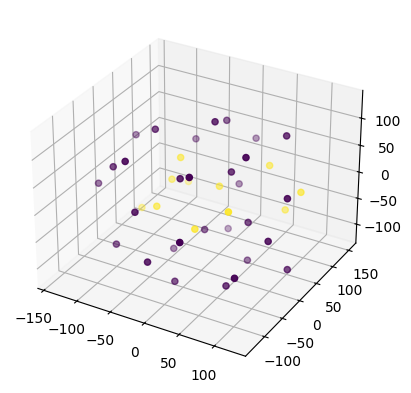

In [45]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import umap

# Initialize t-SNE with 3 components
tsne = TSNE(n_components=3)

# Perform t-SNE projection
projection = tsne.fit_transform(images_latents)

# Plot the projected data in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
c = np.concatenate(([1], sku_names.label.values))
ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], c=c, cmap='viridis')
plt.show()

In [32]:
umap = UMAP(n_components=3)
embeddings_umap = umap.fit_transform(images_latents)

x = embeddings_umap[:, 0]
y = embeddings_umap[:, 1]
z = embeddings_umap[:, 2]


# x = projection[:, 0]
# y = projection[:, 1]
# z = projection[:, 2]

# Create a trace for the scatter plot
trace = go.Scatter3d(x=x,y=y,z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=sku_names.label.values,
        opacity=0.8
    )
)

# Create the layout for the plot
layout = go.Layout(
    title='3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    )
)

# Create the figure and add the trace
fig = go.Figure(data=[trace], layout=layout)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
# Show the plot
fig.show()

In [49]:
umap = UMAP(n_components=39)
embeddings_umap = umap.fit_transform(text_latents)

In [121]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(embeddings_umap)
cluster_labels_umap = kmeans.labels_
print(cluster_labels_umap)

kmeans = KMeans(n_clusters=2)
kmeans.fit(images_latents)
cluster_labels_im = kmeans.labels_
print(cluster_labels_im)

kmeans = KMeans(n_clusters=2)
kmeans.fit(text_latents)
cluster_labels_text = kmeans.labels_
print(cluster_labels_text)

merged = np.c_[images_latents, text_latents]
kmeans = KMeans(n_clusters=2)
kmeans.fit(merged)
cluster_labels_merged = kmeans.labels_
print(cluster_labels_merged)
y = np.concatenate(([1], sku_names.label.values))
print(y)

[0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1
 0 0 0 0]
[0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0
 0 0 0 0]
[1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0
 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 0]
[1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 1 0]


In [122]:
print(np.sum(np.concatenate(([1], sku_names.label.values)) == cluster_labels_umap) / sku_names.shape[0])
print(np.sum(np.concatenate(([1], sku_names.label.values)) == cluster_labels_text) / sku_names.shape[0])
print(np.sum(np.concatenate(([1], sku_names.label.values)) == cluster_labels_im) / sku_names.shape[0])
print(np.sum(np.concatenate(([1], sku_names.label.values)) == cluster_labels_merged) / sku_names.shape[0])
# print(np.sum(np.concatenate(([1], sku_names.label.values)) == cluster_labels) / sku_names.shape[0])

0.275
0.35
0.45
0.525


In [90]:
# prepare classes
# names = set()
names = list()
# sku_seen = set()
images = list()

for row in sku_names.iterrows():
    row = row[1]
    imgpath1, imgpath2 = row.image_url_first, row.image_url_second
    name1, name2 = row.name_first, row.name_second
    names.append(name1)
    names.append(name2)
    # if row.sku_first not in sku_seen:
    #     sku_seen.add(row.sku_first)
    # if row.sku_second not in sku_seen:
    #     sku_seen.add(row.sku_second)
    images.append(read_img(imgpath1))
    images.append(read_img(imgpath2))

In [91]:
clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)

classes = list(names)

templates = ['{}', 'это {}', 'на картинке {}', 'товар {}']

# predict
predictor = ruclip.Predictor(clip, processor, device, bs=8, templates=templates)
with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    images_latents = predictor.get_image_latents(images)

d:\Programming\jupyterD\WORK\market_place\venv_second\Lib\site-packages\huggingface_hub\file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
20it [00:10,  1.86it/s]


In [92]:
text_sims = []
image_sims = []
for ind in range(0, text_latents.shape[0], 2):
    first = text_latents[ind].cpu()
    second = text_latents[ind + 1].cpu()
    text_sims.append(cos_sim(first, second))
    
    first = images_latents[ind].cpu()
    second = images_latents[ind + 1].cpu()
    image_sims.append(cos_sim(first, second))

In [93]:
len(images)

20

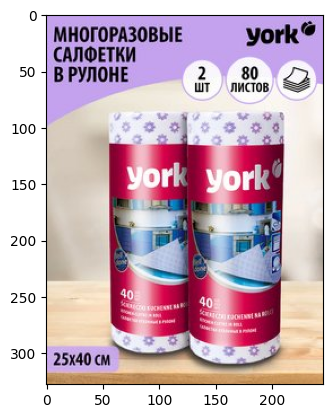

In [94]:
plt.imshow(images[10]);

In [95]:
merged = np.c_[images_latents, text_latents]
merged_sims = list()
for ind in range(0, text_latents.shape[0], 2):
    first = merged[ind]
    second = merged[ind + 1]
    merged_sims.append(cos_sim(first, second))

([0.56900954, 0.92051995, 0.7475329, 0.69002295, 0.7827072],
 [0.57572204, 0.5301629, 0.61180824, 0.49076867, 0.6248687])

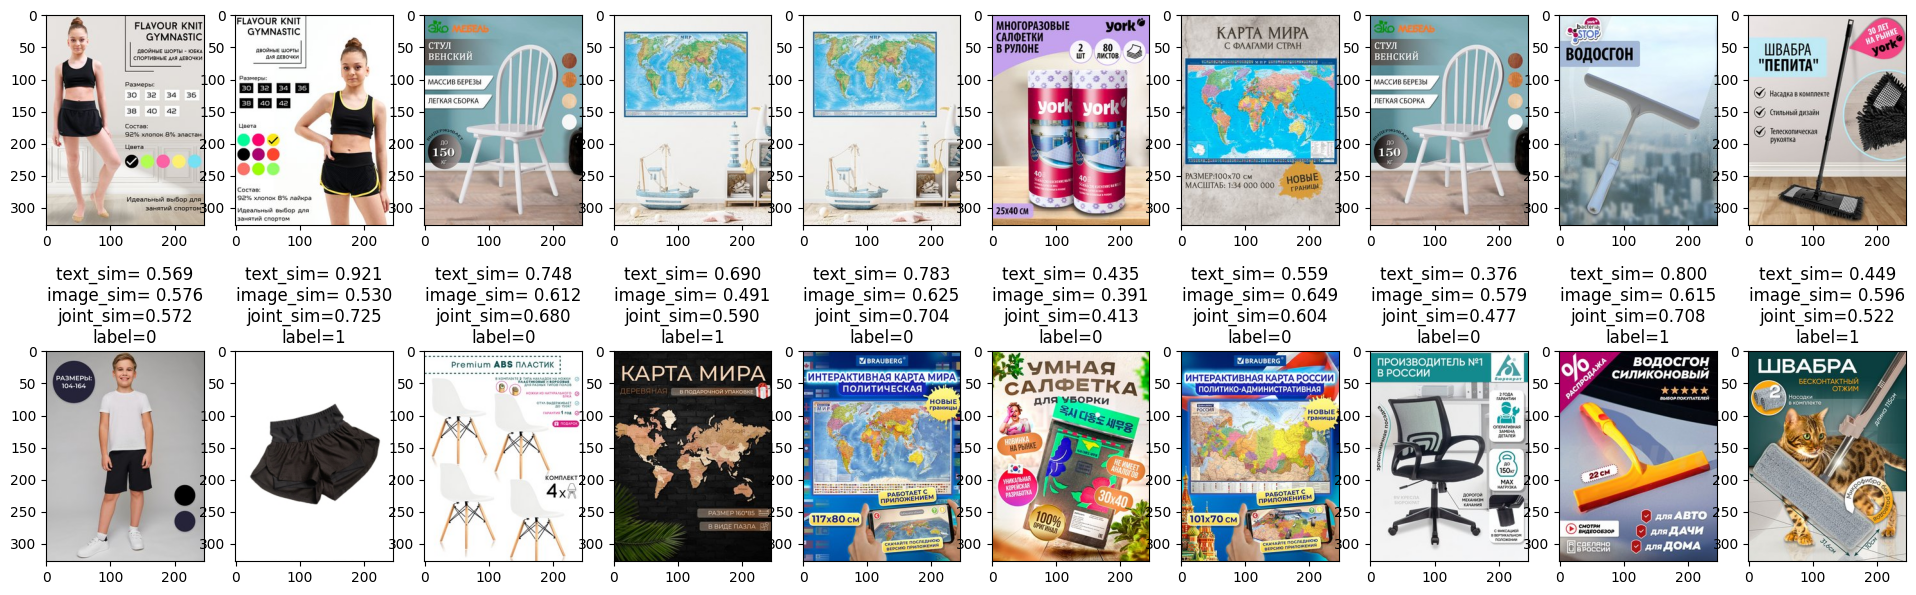

In [104]:
_, ax = plt.subplots(2, 10, figsize=(24, 8))
for i in range(10):
    ax[0, i%10].imshow(images[2*i])
    ax[1, i%10].imshow(images[2*i+1])
    ax[1, i%10].set_title(f'text_sim= {text_sims[i]:.3f}\nimage_sim= {image_sims[i]:.3f}\njoint_sim={merged_sims[i]:.3f}\nlabel={sku_names.iloc[i].label}')
text_sims[:5], image_sims[:5]

In [97]:
sku_names

,sku_first,sku_second,name_first,name_second,image_url_first,image_url_second,label
0,124019640,188068224,Двойные юбка шорты спортивные для девочки,Шорты детские черные,https://basket-09.wb.ru/vol1240/part124019/124...,https://basket-12.wb.ru/vol1880/part188068/188...,0
1,124227858,16580595,Двойные шорты для девочки спортивные для гимна...,Шорты спортивные двойные для гимнастики,https://basket-09.wb.ru/vol1242/part124227/124...,https://basket-02.wb.ru/vol165/part16580/16580...,1
2,13309742,52117396,Стулья для кухни венские,Стулья для кухни со спинкой 4 шт обеденные инт...,https://basket-01.wb.ru/vol133/part13309/13309...,https://basket-04.wb.ru/vol521/part52117/52117...,0
3,64354900,78583225,"Географическая физическая карта Мира ""Мир"" 100...",Карта мира 160х85 настенная из дерева в подаро...,https://basket-04.wb.ru/vol643/part64354/64354...,https://basket-05.wb.ru/vol785/part78583/78583...,1
4,64354900,64129692,"Географическая физическая карта Мира ""Мир"" 100...","Настенная карта мира политическая, интерактивн...",https://basket-04.wb.ru/vol643/part64354/64354...,https://basket-04.wb.ru/vol641/part64129/64129...,0
5,192015329,168790424,Салфетки в рулоне вискозные 80 шт,Салфетка для уборки из микрофибры тряпка униве...,https://basket-13.wb.ru/vol1920/part192015/192...,https://basket-12.wb.ru/vol1687/part168790/168...,0
6,140906524,30145424,Карта мира политическая с новыми границами 100...,Карта России политико-административная интерак...,https://basket-10.wb.ru/vol1409/part140906/140...,https://basket-03.wb.ru/vol301/part30145/30145...,0
7,13309742,146098672,Стулья для кухни венские,Кресло компьютерное офисное стул с подлокотник...,https://basket-01.wb.ru/vol133/part13309/13309...,https://basket-10.wb.ru/vol1460/part146098/146...,0
8,72826737,135176652,Водосгон для мытья окон и стекол,Водосгон автомобильный 22 см,https://basket-05.wb.ru/vol728/part72826/72826...,https://basket-10.wb.ru/vol1351/part135176/135...,1
9,52711454,147454742,Швабра для пола с телескопической рукояткой 84...,Швабра с отжимом без ведра для пола и окон умн...,https://basket-04.wb.ru/vol527/part52711/52711...,https://basket-10.wb.ru/vol1474/part147454/147...,1


In [69]:
pd.DataFrame(np.array([text_sims, image_sims]).T, columns = ['text_sim', 'img_sim']).to_csv('clip_sims.csv', index=False)

In [15]:
pd.DataFrame(cos_sims, columns=['cos_sim']).to_csv('cos_sim.csv', index=False)